# Setup

### Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers, regularizers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_unet import *
from utils.utils_resnet import *

Num GPUs Available:  2


In [2]:
# Load country outlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

### Define some paths and constants.

In [3]:
config = dotenv_values(".env")

# Paths
PATH_ERA5 = config['PATH_ERA5']
PATH_EOBS = config['PATH_EOBS']

# Some constants
G = 9.80665

# Options
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]
LEVELS = [500, 850, 1000]
LONS_INPUT = [-25, 30]
LATS_INPUT = [30, 75]
LONS_PREC = [-25, 30]
LATS_PREC = [30, 75]
BATCH_SIZE = 1024
PRECIP_DATA = 'ERA5' # Options: ERA5, E-OBS

# Data preparation

## Target variable: precipitation field

In [4]:
# Load precipitation
if PRECIP_DATA == 'ERA5':
    pr = get_nc_data(PATH_ERA5 + '/precipitation/orig_grid/daily/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.tp
elif PRECIP_DATA in ['E-OBS', 'EOBS']:
    pr = get_nc_data(PATH_EOBS + '/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.rr
    pr = pr.coarsen(lon=5, lat=5, boundary="trim").mean()
    pr = pr.fillna(0) # Over the seas. Not optimal...
else:
    raise('Precipitation data not well defined')

Extracting data for the period 1979-01-01 - 2020-12-31


In [5]:
# Add a dimension to be used as channel in the DNN
pr = pr.expand_dims('level', -1)
pr

,Array,Chunk
Bytes,4.57 GiB,111.70 MiB
Shape,"(15340, 181, 221, 1)","(366, 181, 221, 1)"
Count,339 Tasks,42 Chunks
Type,float64,numpy.ndarray


In [6]:
lats_y = pr.lat.to_numpy()
lons_y = pr.lon.to_numpy()

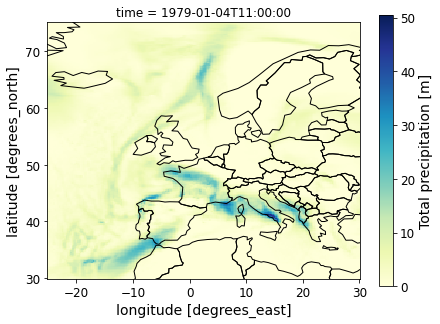

In [7]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1)
pr[2,:,:].plot(ax=ax, cmap=mpl.cm.YlGnBu)
_ = world.boundary.plot(ax=ax, lw=1, color='k')

## Input data: meteorological fields

In [8]:
# Load geopotential height
z = get_era5_data(PATH_ERA5 + '/geopotential/grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
z = z.sel(level=LEVELS)

# Get Z in geopotential height (m)
z.z.values = z.z.values/G

# Load temperature
t2m = get_era5_data(PATH_ERA5 + '/temperature/grid1/Grid1_*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
t2m['time'] = pd.DatetimeIndex(t2m.time.dt.date)
t2m = t2m.rename_vars({'T2MMEAN': 't'})

# Load relative humidity
rh = get_era5_data(PATH_ERA5 + '/relative_humidity/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
rh['time'] = pd.DatetimeIndex(rh.time.dt.date)
rh = rh.sel(level=LEVELS)

# Load total column water
tcw = get_era5_data(PATH_ERA5 + '/total_column_water/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
tcw['time'] = pd.DatetimeIndex(rh.time.dt.date)

# Load wind components
u850 = get_era5_data(PATH_ERA5 + '/U_wind/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
u850['time'] = pd.DatetimeIndex(u850.time.dt.date)
v850 = get_era5_data(PATH_ERA5 + '/V_wind/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
v850['time'] = pd.DatetimeIndex(v850.time.dt.date)

# Checking dimensions
print('dimension of pr:', pr.dims)
print('dimension of z', z.dims)
print('dimension of t2m:', t2m.dims)
print('dimension of rh:', rh.dims)
print('dimension of tcw:', tcw.dims)
print('dimension of u:', u850.dims)
print('dimension of v:', v850.dims)


Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31
dimension of pr: ('time', 'lat', 'lon', 'level')
dimension of z Frozen({'time': 15341, 'lon': 56, 'lat': 46, 'level': 3})
dimension of t2m: Frozen({'time': 15341, 'lon': 56, 'lat': 46})
dimension of rh: Frozen({'time': 15341, 'lon': 56, 'lat': 46, 'level': 3})
dimension of tcw: Frozen({'time': 15341, 'lon': 56, 'lat': 46})
dimension of u: Frozen({'time': 15341, 'lon': 56, 'lat': 46})
dimension of v: Frozen({'time': 15341, 'lon': 56, 'lat': 46})


In [9]:
# Merge arrays
X = xr.merge([z, t2m, rh, tcw, u850, v850])
X

<xarray.Dataset>
Dimensions:  (lat: 46, time: 15341, lon: 56, level: 3)
Coordinates:
  * lat      (lat) float64 30.0 31.0 32.0 33.0 34.0 ... 71.0 72.0 73.0 74.0 75.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * lon      (lon) float64 -25.0 -24.0 -23.0 -22.0 -21.0 ... 27.0 28.0 29.0 30.0
  * level    (level) float64 500.0 850.0 1e+03
Data variables:
    z        (time, level, lat, lon) float32 5.863e+03 5.869e+03 ... 143.3 149.0
    t        (time, lat, lon) float32 dask.array<chunksize=(15341, 46, 56), meta=np.ndarray>
    r        (time, level, lat, lon) float32 dask.array<chunksize=(365, 3, 46, 56), meta=np.ndarray>
    tcwv     (time, lat, lon) float32 dask.array<chunksize=(365, 46, 56), meta=np.ndarray>
    u        (time, lat, lon) float32 dask.array<chunksize=(365, 46, 56), meta=np.ndarray>
    v        (time, lat, lon) float32 dask.array<chunksize=(365, 46, 56), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Jan 12 11:54:40 2022: cdo -f nc -remapbil,/storage/home...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [10]:
# Invert lat axis if needed
if X.lat[0].values < X.lat[1].values:
    X = X.reindex(lat=list(reversed(X.lat)))
    
# Get axes
lats_x = X.lat
lons_x = X.lon

### Split data and transform

In [11]:
# Split into training and test
X_train_full = X.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
X_test = X.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

pr_train_full = pr.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
pr_test = pr.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

In [12]:
# Create a data generator
dic = {'z': LEVELS,
       't': None,
       'r': LEVELS,
       'tcwv': None,
       'u': None,
       'v': None}

from utils.utils_ml import *

YY_VALID = 2005

dg_train = WeatherDataGenerator(X_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                pr_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                dic, batch_size=BATCH_SIZE, load=True)
dg_valid = WeatherDataGenerator(X_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                pr_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                dic, mean=dg_train.mean, std=dg_train.std,
                                batch_size=BATCH_SIZE, load=True)
dg_test = WeatherDataGenerator(X_test, pr_test, dic,
                               mean=dg_train.mean, std=dg_train.std,
                               batch_size=BATCH_SIZE, load=True, shuffle=False)


Loading data into RAM
Loading data into RAM
Loading data into RAM


In [13]:
i_shape = dg_train.X.shape[1:]
o_shape = dg_train.y.shape[1:]

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')

X shape: (46, 56, 10)
y shape: (181, 221, 1)


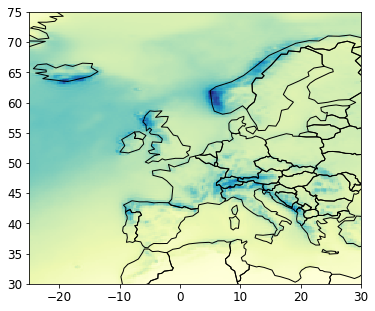

In [14]:
# Plotting the mean precipitation
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1)
vals = np.mean(dg_train.y, axis=0).squeeze()
im = ax.pcolormesh(lons_y, lats_y, vals, cmap=mpl.cm.YlGnBu, shading='auto')
world.boundary.plot(ax=ax, lw=1, color='k')
_ = ax.set_xlim(min(lons_y), max(lons_y))
_ = ax.set_ylim(min(lats_y), max(lats_y))

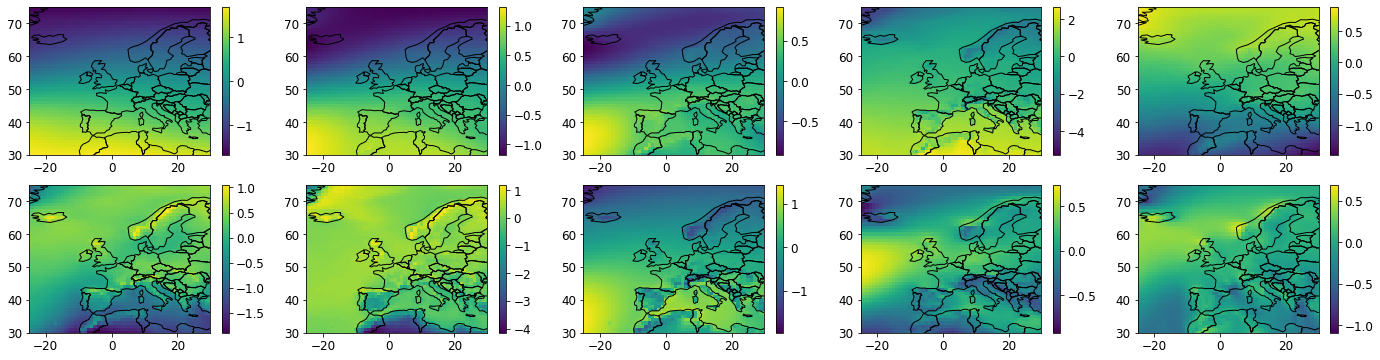

In [15]:
# Plotting the mean of the predictors
n_figs = len(dg_train.X[0,0,0,:])
ncols = 5
nrows = -(-n_figs // ncols)
fig, axes = plt.subplots(figsize=(24, 3*nrows), ncols=ncols, nrows=nrows)
for i in range(n_figs):
    i_row = i // ncols
    i_col = i % ncols
    ax = axes[i_row, i_col]
    vals = np.mean(dg_train.X[:,:,:,i], axis=0).to_numpy()
    im = ax.pcolormesh(lons_x, lats_x, vals, shading='auto')
    world.boundary.plot(ax=ax, lw=1, color='k')
    _ = ax.set_xlim(min(lons_x), max(lons_x))
    _ = ax.set_ylim(min(lats_x), max(lats_x))
    fig.colorbar(im, ax=ax)


# Model creation

In [69]:
class DeepFactory(tf.keras.Model):
    """
    Model factory.
    """

    def __init__(self, arch, input_size, output_size, for_extremes=False, latent_dim=128, dropout_rate=0.2, 
                 use_batch_norm=True, inner_activation='relu', output_scaling=1, output_crop=None):
        super(DeepFactory, self).__init__()
        self.arch = arch
        self.input_size = list(input_size)
        self.output_size = list(output_size)
        self.for_extremes = for_extremes
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.inner_activation = inner_activation
        self.output_scaling = output_scaling
        self.output_crop = output_crop
        
        self.last_activation = 'relu'
        if for_extremes:
            self.last_activation = 'sigmoid'

        if arch == 'Davenport-2021':
            self.build_Davenport_2021()
        elif arch == 'CNN-v1':
            self.build_CNN_v1()
        elif arch == 'CNN-v2':
            self.build_CNN_v2()
        elif arch == 'CNN-v3':
            self.build_CNN_v3()
        elif arch == 'Unet-v1':
            self.build_Unet_v1()
        else:
            raise('The architecture was not correctly defined')
        
        
    def build_Davenport_2021(self):
        """
        Based on: Davenport, F. V., & Diffenbaugh, N. S. (2021). Using Machine Learning to 
        Analyze Physical Causes of Climate Change: A Case Study of U.S. Midwest Extreme Precipitation. 
        Geophysical Research Letters, 48(15). https://doi.org/10.1029/2021GL093787
        """
        
        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        x = layers.Conv2D(16, 3, padding='same', activity_regularizer=regularizers.l2(0.01))(inputs)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.SpatialDropout2D(self.dropout_rate)(x) # In original: simple Dropout
        x = layers.Conv2D(16, 3, padding='same', activity_regularizer=regularizers.l2(0.01))(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.SpatialDropout2D(self.dropout_rate)(x) # In original: simple Dropout
        x = layers.Flatten()(x)                
        x = layers.Dense(self.latent_dim, activity_regularizer=regularizers.l2(0.001))(x) # In original: 16
        x = layers.Activation('relu')(x)

        next_size = self.get_size_for(stride_factor=4)

        # Upsampling. In original: no decoder
        #x = layers.InputLayer(input_shape=(self.latent_dim,))(x)
        x = layers.Dense(np.prod(next_size), activation='relu')(x)
        x = layers.Reshape(target_shape=next_size)(x)
        x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
        x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
        x = layers.Conv2DTranspose(1, 3, strides=1, padding='same', activation=self.last_activation)(x)
        outputs = self.final_cropping_block(x)
 
        self.model = keras.Model(inputs, outputs, name="Davenport-2021")
        
        
    def build_CNN_v1(self):

        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        x = self.conv_block(inputs, 32, 3, stride=2, with_pooling=False)
        x = self.conv_block(x, 64, 3, stride=2, with_pooling=False)
        x = layers.Flatten()(x)
        x = self.dense_block(x, self.latent_dim, activation='sigmoid', with_dropout=False)

        next_size = self.get_size_for(stride_factor=4)

        # Upsampling
        #x = layers.InputLayer(input_shape=(self.latent_dim,))(x)
        x = self.dense_block(x, np.prod(next_size))
        x = layers.Reshape(target_shape=next_size)(x)
        x = self.deconv_block(x, 64, 3, stride=2)
        x = self.deconv_block(x, 32, 3, stride=2)
        x = self.deconv_block(x, 1, 3, activation=self.last_activation, with_batchnorm=False, with_dropout=False)
        outputs = self.final_cropping_block(x)

        self.model = keras.Model(inputs, outputs, name="CNN-v1")
        

    def build_CNN_v2(self):
        
        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        x = self.conv_block(inputs, 8, 3, with_batchnorm=False, with_pooling=False, with_dropout=False)
        x = self.conv_block(x, 8, 3, stride=2, with_pooling=False)
        x = self.conv_block(x, 16, 3, stride=2, with_pooling=False)
        x = self.conv_block(x, 16, 3, stride=2, with_pooling=False)
        x = self.conv_block(x, 32, 3, stride=2, with_pooling=False)
        x = layers.Flatten()(x)
        x = self.dense_block(x, self.latent_dim, activation='sigmoid', with_dropout=False)

        next_size = self.get_size_for(stride_factor=16)

        # Upsampling
        #x = layers.InputLayer(input_shape=(self.latent_dim,))(x)
        x = self.dense_block(x, np.prod(next_size))
        x = layers.Reshape(target_shape=next_size)(x)
        x = self.deconv_block(x, 16, 3, stride=2)
        x = self.deconv_block(x, 16, 3, stride=2)
        x = self.deconv_block(x, 16, 3, stride=2)
        x = self.deconv_block(x, 8, 3, stride=2)
        x = self.conv_block(x, 1, 3, activation=self.last_activation, with_batchnorm=False, with_pooling=False, with_dropout=False)
        outputs = self.final_cropping_block(x)
        
        self.model = keras.Model(inputs, outputs, name="CNN-v2")
        
        
    def build_CNN_v3(self):

        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        x = self.conv_block(inputs, 8, 3, with_pooling=False)
        x = self.conv_block(x, 8, 3, stride=2, with_pooling=False)
        x = self.conv_block(x, 16, 3, stride=2, with_pooling=False)
        x = self.conv_block(x, 16, 3, stride=2, with_pooling=False)
        x = self.conv_block(x, 32, 3, stride=2, with_pooling=False)
        x = self.conv_block(x, 32, 3, stride=2, with_pooling=False)
        x = self.conv_block(x, 64, 3, stride=2, with_pooling=False)
        x = layers.Flatten()(x)
        x = self.dense_block(x, self.latent_dim, activation='sigmoid', with_dropout=False)
        
        next_size = self.get_size_for(stride_factor=64)

        # Upsampling
        #x = layers.InputLayer(input_shape=(self.latent_dim,))(x)
        x = self.dense_block(x, np.prod(next_size))
        x = layers.Reshape(target_shape=next_size)(x)
        x = self.deconv_block(x, 32, 3, stride=2)
        x = self.deconv_block(x, 32, 3, stride=2)
        x = self.deconv_block(x, 16, 3, stride=2)
        x = self.deconv_block(x, 16, 3, stride=2)
        x = self.deconv_block(x, 16, 3, stride=2)
        x = self.deconv_block(x, 8, 3, stride=2)
        x = self.conv_block(x, 1, 3, activation=self.last_activation, with_batchnorm=False, with_pooling=False, with_dropout=False)
        outputs = self.final_cropping_block(x)
        
        self.model = keras.Model(inputs, outputs, name="CNN-v3")
        
    
    def build_Unet_v1(self):
        """
        Based on: U-Net: https://github.com/nikhilroxtomar/Unet-for-Person-Segmentation/blob/main/model.py
        """
        
        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        
        # Pad if necessary
        x = self.padding_block(inputs, 8)
        
        s1, p1 = self.unet_encoder_block(x, 64)
        s2, p2 = self.unet_encoder_block(p1, 128)
        s3, p3 = self.unet_encoder_block(p2, 256)
        s4, p4 = self.unet_encoder_block(p3, 512)
        
        b1 = self.conv_block(p4, 1024, 3, with_pooling=False)

        # Upsampling
        d1 = self.unet_decoder_block(b1, s4, 512)
        d2 = self.unet_decoder_block(d1, s3, 256)
        d3 = self.unet_decoder_block(d2, s2, 128)
        d4 = self.unet_decoder_block(d3, s1, 64)
        
        # Additional upsampling for downscaling
        x = self.handle_output_scaling(d4)

        x = self.conv_block(x, 1, 1, activation=self.last_activation, with_batchnorm=False, with_pooling=False, with_dropout=False)
        outputs = self.final_cropping_block(x)

        self.model = keras.Model(inputs, outputs, name="U-Net-v1")
        

    def unet_encoder_block(self, input, filters, kernel_size=3):
        x = self.conv_block(input, filters, kernel_size, with_pooling=False)
        x = self.conv_block(x, filters, kernel_size, with_pooling=False)
        p = layers.MaxPooling2D(pool_size=2)(x)
        
        return x, p

    
    def unet_decoder_block(self, input, skip_features, filters, conv_kernel_size=3, deconv_kernel_size=2):
        x = self.deconv_block(input, filters, deconv_kernel_size, stride=2, with_batchnorm=False, with_dropout=False)
        
        # Crop if sizes differ between skip features and deconvolution outputs
        h_x, w_x = x.get_shape().as_list()[1:3]
        h_s, w_s = skip_features.get_shape().as_list()[1:3]
        dh = h_s - h_x
        dw = w_s - w_x
        print("----------------------")
        print(f'h_x={h_x}')
        print(f'w_x={w_x}')
        print(f'h_s={h_s}')
        print(f'w_s={w_s}')
        print(f'dh={dh}')
        print(f'dw={dw}')
        assert dh >= 0 and dw >= 0, f"U-net: skip features not expected to be smaller than the deconvolution outputs; got dh={dh}, dw={dw}"
        if dh > 0 or dw > 0:
            skip_features = layers.Cropping2D(cropping=((dh//2, dh-dh//2), (dw//2, dw-dw//2)))(skip_features)
            #skip_features = layers.Reshape(target_shape=(h_x, w_x),)(skip_features)
        
        x = layers.Concatenate()([x, skip_features])
        x = self.conv_block(x, filters, conv_kernel_size, with_pooling=False, with_dropout=False)
        x = self.conv_block(x, filters, conv_kernel_size, with_pooling=False, with_dropout=False)

        return x
        
        
    def conv_block(self, input, filters, kernel_size=3, stride=1, padding='same', initializer='he_normal', activation='default', 
                   with_batchnorm=True, with_pooling=True, with_dropout=True):
        if activation == 'default':
            activation=self.inner_activation
            
        x = layers.Conv2D(filters, kernel_size, strides=(stride, stride), padding=padding, kernel_initializer=initializer)(input)
        if with_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        if with_pooling:
            x = layers.MaxPooling2D(pool_size=2)(x)
        if with_dropout:
            x = layers.SpatialDropout2D(self.dropout_rate)(x)
        
        return x
    
    
    def deconv_block(self, input, filters, kernel_size=3, stride=1, padding='same', initializer='he_normal', activation='default', 
                     with_batchnorm=True, with_dropout=False):
        if activation == 'default':
            activation=self.inner_activation
            
        x = layers.Conv2DTranspose(filters, kernel_size, strides=(stride, stride), padding=padding, kernel_initializer=initializer)(input)
        if with_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        if with_dropout:
            x = layers.SpatialDropout2D(self.dropout_rate)(x)
        
        return x
    
    
    def dense_block(self, input, units, activation='default', initializer='he_normal', with_dropout=True):
        if activation == 'default':
            activation=self.inner_activation
            
        x = layers.Dense(units, activation=activation, kernel_initializer=initializer)(input)
        if with_dropout:
            x = layers.Dropout(self.dropout_rate)(x)
            
        return x

    
    def handle_output_scaling(self, input, with_batchnorm=True):
        if self.output_scaling > 1:
            if self.output_scaling == 2:
                x = self.deconv_block(input, 64, 3, stride=2, with_batchnorm=with_batchnorm)
            elif self.output_scaling == 3:
                x = self.deconv_block(dinput4, 64, 3, stride=3, with_batchnorm=with_batchnorm)
            elif self.output_scaling == 4:
                x = self.deconv_block(input, 64, 3, stride=2, with_batchnorm=with_batchnorm)
                x = self.deconv_block(x, 64, 3, stride=2, with_batchnorm=with_batchnorm)
            elif self.output_scaling == 5:
                x = self.deconv_block(input, 64, 3, stride=3, with_batchnorm=with_batchnorm)
                x = self.deconv_block(x, 64, 3, stride=2, with_batchnorm=with_batchnorm)
            else:
                raise('Level of downscaling not implemented')
        
        if self.output_crop:
            raise('Manual cropping not yet implemented')
            
        return x
            
        
    def padding_block(self, x, factor):
        h, w = x.get_shape().as_list()[1:3]
        dh = 0
        dw = 0
        if h % factor > 0:
            dh = factor - h % factor
        if w % factor > 0:
            dw = factor - w % factor
        if dh > 0 or dw > 0:
            top_pad = dh//2
            bottom_pad = dh//2 + dh%2
            left_pad = dw//2
            right_pad = dw//2 + dw%2
            x = layers.ZeroPadding2D(padding=((top_pad, bottom_pad), (left_pad, right_pad)))(x)
        
        return x
        
        
    def final_cropping_block(self, x):
        # Compute difference between reconstructed width and hight and the desired output size.
        h, w = x.get_shape().as_list()[1:3]
        h_tgt, w_tgt = self.output_size[:2]
        dh = h - h_tgt
        dw = w - w_tgt

        # Add to decoder cropping layer and final reshaping
        x = layers.Cropping2D(cropping=((dh//2, dh-dh//2), (dw//2, dw-dw//2)))(x)
        x = layers.Reshape(target_shape=self.output_size,)(x)
        
        return x
        

    def get_size_for(self, stride_factor):
        next_shape = self.output_size.copy()
        next_shape[0] = int(np.ceil(next_shape[0]/stride_factor))
        next_shape[1] = int(np.ceil(next_shape[1]/stride_factor))

        return next_shape

        
    def call(self, x):
        return self.model(x)
    


In [70]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)
                                            
# Model hyperparameters
hp_model = {'latent_dim': 128,
            'dropout_rate': 0.2}

# Training hyperparameters
hp_training = {'epochs': 100,
               #'callbacks': [callback]
              }
lr = .0004

In [71]:
output_scaling = 2
output_crop = None

In [72]:
models = {
          #'dav-orig': {'model': 'Davenport-2021', 'options': {'latent_dim': 16}}, # original
          #'dav-64': {'model': 'Davenport-2021', 'options': {'latent_dim': 64}},
          #'cnnv1': {'model': 'CNN-v1', 'options': {'latent_dim': 64}},
          #'cnnv2': {'model': 'CNN-v2', 'options': {'latent_dim': 64}},
          #'cnnv3': {'model': 'CNN-v3', 'options': {'latent_dim': 64}},
          'unet1': {'model': 'Unet-v1', 'options': {'output_scaling': output_scaling, 'output_crop': output_crop}},
         }

In [73]:
# Predict the amount of precipitation
df_prec = pd.DataFrame(columns = ['id', 'name', 'params', 'train_pr_rmse', 'valid_pr_rmse', 'test_pr_rmse', 'train_xtr', 'valid_xtr', 'test_xtr'])

for m_id in models:
    # Clear session and set tf seed
    keras.backend.clear_session()
    tf.random.set_seed(42)

    # Extract model name and options
    model = models[m_id]['model']
    opts = models[m_id]['options']
    hp_model_new = hp_model.copy()
    hp_model_new.update(opts)
    print(f'Running: {m_id} - {model} - {hp_model_new}')
    df_prec = df_prec.append({'id': m_id, 'name': model, 'params': hp_model_new}, ignore_index=True)

    # Create the model and compile
    m = DeepFactory(model, i_shape, o_shape, for_extremes=False, **hp_model_new)
    # Warning: When using regularizers, the loss function is the entire loss, ie (loss metrics) + (regularization term)!
    # But the loss displayed as part of the metrics, is only the loss metric. The regularization term is not added there. -> can be different!!
    m.compile(loss='mse', metrics=['mse'], optimizer=tf.optimizers.Adam(learning_rate = lr))

    # Train
    hist = m.fit(dg_train, validation_data=dg_valid, verbose=0, **hp_training)
    
    # Assess and save scores
    y_pred_train = m.predict(dg_train.X.to_numpy())
    y_pred_valid = m.predict(dg_valid.X.to_numpy())
    y_pred_test = m.predict(dg_test.X.to_numpy())
    df_prec.at[df_prec.index[-1], 'train_pr_rmse'] = np.sqrt(np.square(np.subtract(dg_train.y.to_numpy(), y_pred_train)).mean())
    df_prec.at[df_prec.index[-1], 'valid_pr_rmse'] =  np.sqrt(np.square(np.subtract(dg_valid.y.to_numpy(), y_pred_valid)).mean())
    df_prec.at[df_prec.index[-1], 'test_pr_rmse'] =  np.sqrt(np.square(np.subtract(dg_test.y.to_numpy(), y_pred_test)).mean())
    
    print(df_prec.iloc[-1])

    # Plot training evolution
    pd.DataFrame(hist.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()    


Running: unet1 - Unet-v1 - {'latent_dim': 128, 'dropout_rate': 0.2, 'output_scaling': 2, 'output_crop': None}
----------------------
h_x=6
w_x=6
h_s=6
w_s=7
dh=0
dw=1
----------------------
h_x=12
w_x=12
h_s=12
w_s=14
dh=0
dw=2
----------------------
h_x=24
w_x=24
h_s=24
w_s=28
dh=0
dw=4
----------------------
h_x=48
w_x=48
h_s=48
w_s=56
dh=0
dw=8


ValueError: The `1st entry of cropping` argument must be a tuple of 2 integers. Received: (-43, -42) including {-43, -42} that does not satisfy the requirement `>= 0`.

In [ ]:
df_prec

In [ ]:
# Predict precipitation extremes
METRICS = [
    tf.metrics.CategoricalAccuracy(name='accuracy'),
    tf.metrics.Precision(class_id = 1, name='precision'),
    tf.metrics.Recall(class_id = 1, name='recall')
]

history_xtr = []

for model in models:
    m = EDMF(model, i_shape, o_shape, for_extremes=True, **hp_model)
    m.compile(loss=tf.losses.CategoricalCrossentropy(), 
              optimizer=tf.optimizers.Adam(learning_rate = lr),
              metrics=METRICS)

    hist = m.fit(dg_train, validation_data=dg_valid, **hp_training)
    history_xtr.append(hist)

    # Plot training evolution
    pd.DataFrame(hist.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()